<a href="https://colab.research.google.com/github/manamuadachi/manamuadachi.github.io/blob/master/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
! pip install segmentation_models

     |████████████████████████████████| 51kB 2.6MB/s 


In [ ]:
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import random
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
random.seed(1)

cho=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/cho.npy")
cho=list(cho)

train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")
sample_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/sample_submission.csv")



#先頭番号
a=[]
#連続したラベル
b=[]
cho=[]
index=0
for i in range(3,7095-3):
  a3=train_df.iat[i,0]
  b3=train_df.iat[i+1,0]
  c3=train_df.iat[i+2,0]
  k3=[]
  if a3!=b3 and b3==c3:
    a.append(i)
    k3.append(train_df.iat[i,1])
    k3.append(train_df.iat[i,1])
  elif b3==c3:
    k3.append(train_df.iat[i,1])
  elif a3==b3 and b3!=c3:
    b.append(k3)
  else:
    pass



#train_df(トレーニングデータフレーム)の特定の行(gyo)を入力とし、(クラスラベル,マスク行列)を出力、0がなにもない場所、1がひび割れ
def mask(gyo):
	train=train_df.iat[gyo,2].split(" ")
	train = [int(num) for num in train]
	mask = np.zeros(256*1600)
	mask=np.ravel(mask)

	for i in range(int(len(train)/2)):
		mask[train[2*i]:train[2*i]+train[2*i+1]-1]=[1]*(train[2*i+1]-1)
	mask=mask.reshape(1600,256)
	mask=mask.T
	mask.reshape(256,1600)
	mask=np.array(mask)
	return(train_df.iat[gyo,1],mask)
 

#ランダム幾何変換関数
def crop(A,B):
  B0=B[0]
  B1=B[1]
  B2=B[2]
  B3=B[3]
  if random.choice([0, 1]) == 0:
    A=cv2.flip(A,0)
    B0=cv2.flip(B0,0)
    B1=cv2.flip(B1,0)
    B2=cv2.flip(B2,0)
    B3=cv2.flip(B3,0)
  else:
    pass
  if random.choice([0,1])==0:
    A=cv2.flip(A,1)
    B0=cv2.flip(B0,1)
    B1=cv2.flip(B1,1)
    B2=cv2.flip(B2,1)
    B3=cv2.flip(B3,1)
  else:
    pass
  """
  rows,cols,aa = A.shape
  m1=random.choice(list(range(-5,5)))
  m2=random.choice(list(range(-5,5)))
  A = cv2.warpAffine(A,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B0 = cv2.warpAffine(B0,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B1 = cv2.warpAffine(B1,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B2 = cv2.warpAffine(B2,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B3 = cv2.warpAffine(B3,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  m3 = random.choice(list(range(-2,2)))
  A = cv2.warpAffine(A,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B0 = cv2.warpAffine(B0,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B1 = cv2.warpAffine(B1,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B2 = cv2.warpAffine(B2,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B3 = cv2.warpAffine(B3,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  ra=random.uniform(-0.1, 0.1)
  img= np.zeros([rows,cols])
  if random.choice([0, 1]) == 0:
    A=np.reshape(A,(256,1600,1))
    img=np.reshape(img,(256,1600,1))
    for i in range(cols):
      weight = 1+((i*ra)/cols)
      img[:,i] = cv2.addWeighted(A[:,i],0.5*weight,A[:,i],0.5*weight,0)
    A=img
  else:
    img=img.T
    A=A.T
    A=np.reshape(A,(1600,256,1))
    img=np.reshape(img,(1600,256,1))
    for i in range(rows):
      weight = 1+((i*ra)/rows)
      img[:,i] = cv2.addWeighted(A[:,i],0.5*weight,A[:,i],0.5*weight,0)
    img=np.reshape(img,(256,1600))
    A=img.T
  """
  A=A*random.uniform(0.95, 1.05)
  B=[B0,B1,B2,B3]
  return(A,B)


#XX入力YY出力データテンソルを作る場合のコード
"""
XX=[]
YY=[]
for i in range(データ数):
	y=mask(i)
	imageid=train_df.iat[i,0]
	x = cv2.imread("C:/Users/victory adachi/pyworks/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
	#x=np.array(Image.open("C:/Users/victory adachi/pyworks/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid))
	x=x/255
	x=np.reshape(x, (256,1600,1))
	X=x
	zeros=np.zeros([256,1600])
	Y=[]
	for j in range(4):
		if y[0]==j+1:
			Y.append(y[1])
		else:
			Y.append(zeros)
	Y=np.stack(Y,2)
	XX.append(X)
	YY.append(Y)
X_train=np.array(XX)
Y_train=np.array(YY)
"""

 
#data generator にて入出力を作る場合のコード
def batch_iter(data_size, batch_size):
    data_size=int((4/5)*data_size)
    num_batches_per_epoch = int(data_size / batch_size)

    def data_generator():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                k=random.sample(list(range(data_size)), len(list(range(data_size))) )
                XX=[]
                YY=[]
                zeros=np.zeros([256,1600])
                for i in range(batch_size):
                	imageid=train_df.iat[k[i+start_index],0]

                	y=mask(k[i+start_index])
                	if k[i+start_index] in cho:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(k[i+start_index])+"_gyo.jpg", cv2.IMREAD_GRAYSCALE)                  
                	else:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
                	x=x/255
                	Y=[]
                	for j in range(4):
                		if y[0]==j+1:
                			Y.append(y[1])
                		else:
                			Y.append(zeros)
                	#x,Y=crop(x,Y)
                	x=np.reshape(x, (256,1600,1))
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator()
#4:1で学習
def batch_iter2(data_size, batch_size):
    num_batches_per_epoch = int(data_size / (5*batch_size))
    def data_generator2():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = int((4*data_size)/5+batch_num * batch_size)
                l0=[0]*(int((4*data_size)/5))
                l=random.sample(list(range(int((4*data_size)/5),data_size)), len(list(range(int((4*data_size)/5),data_size))) )
                l=l0+l
                XX=[]
                YY=[]
                zeros=np.zeros([256,1600])
                for i in range(batch_size):
                	imageid=train_df.iat[l[i+start_index],0]
                	y=mask(l[i+start_index])
                	if l[i+start_index] in cho:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(l[i+start_index])+"_gyo.jpg", cv2.IMREAD_GRAYSCALE)                  
                	else:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
                	x=x/255
                	Y=[]
                	for j in range(4):
                		if y[0]==j+1:
                			Y.append(y[1])
                		else:
                			Y.append(zeros)
                  
                	#x,Y=crop(x,Y)
                	x=np.reshape(x, (256,1600,1))
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator2()




#履歴
def plot_history(history, outdir):
    # 精度の履歴をプロット
    plt.figure()
    plt.plot(history.history['dice_coef'], marker='.')
    plt.plot(history.history['val_dice_coef'], marker='.')
    plt.title('model dice_coef')
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###
    plt.savefig(os.path.join(outdir, 'dice_coef5.png'))
    # 損失の履歴をプロット
    plt.figure()
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###保存
    plt.savefig(os.path.join(outdir, 'loss5.png'))




#loss func
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)




#model
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

model = build_model((256, 1600, 1))
"""
# LOAD UNET WITH PRETRAINING FROM IMAGENET
#preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

#モデルのサマリ
#model.summary()
#plot_model(model, show_shapes=True, to_file='result_steel/model.png')


callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(
                 '../data/temp/mnist_sequential_{epoch:03d}_{val_loss:.4f}.h5',
                 save_best_only=True
             )]
"""
#history=model.fit(XX, YY, batch_size=128, epochs=7,validation_split=0.2, callbacks=callbacks)

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)


#学習開始
history=model.fit_generator(batch_iter(7040, 16)[1], batch_iter(7040, 16)[0],validation_data=batch_iter2(7040,4)[1],validation_steps=batch_iter2(7040,4)[0], epochs=15,verbose=1,callbacks=[checkpoint])




# 学習履歴をプロット
plot_history(history, '/content/drive/My Drive/kaggle_data/rireki1')

###

# 重みの保存
model.save_weights('/content/drive/My Drive/kaggle_data/weight1/weights.5')


"""
#evaluation
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()

model.load_weights('model.h5')
test_df = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )
    
    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        base_path='/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/test_images',
        target_df=sub_df,
        batch_size=1,
        n_classes=4
    )
    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1,
        use_multiprocessing=False
    )

    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)
"""
"""


                	if k[i+start_index] in a:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
                	  x=x/255
                	  num=a.index(k[i+start_index])
                	  Y=[]
                	  for j in [1,2,3,4]:
                	    if j in b[num]:
                	      Y.apped(mask(k[i+start_index]+b[num].index(j))[0])
                	    else:
                	      Y.append(zeros)
                	  x,Y=crop(x,Y)
                	  x=np.reshape(x, (256,1600,1))
                	  Y=np.stack(Y,2)
                	  XX.append(x)
                	  YY.append(Y)
                	else:
                	  pass
"""
"""



                	if l[i+start_index] in a:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
                	  x=x/255
                	  num=a.index(l[i+start_index])
                	  Y=[]
                	  for j in [1,2,3,4]:
                	    if j in b[num]:
                	      Y.apped(mask(l[i+start_index]+b[num].index(j))[0])
                	    else:
                	      Y.append(zeros)
                	  x,Y=crop(x,Y)
                	  x=np.reshape(x, (256,1600,1))
                	  Y=np.stack(Y,2)
                	  XX.append(x)
                	  YY.append(Y)
                	else:
                	  pass
"""


In [ ]:
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import random
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
random.seed(1)

cho=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/cho.npy")
cho=list(cho)

train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")
sample_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/sample_submission.csv")

nume=0
"""
epoval=[0,200,400,600,800]
x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/0002cc93b.jpg")

x = x[0 : 256, epoval[nume%5]: epoval[nume%5]+400]
print(x.shape)
"""

#train_df(トレーニングデータフレーム)の特定の行(gyo)を入力とし、(クラスラベル,マスク行列)を出力、0がなにもない場所、1がひび割れ
def mask(gyo):
	train=train_df.iat[gyo,2].split(" ")
	train = [int(num) for num in train]
	mask = np.zeros(256*1600)
	mask=np.ravel(mask)

	for i in range(int(len(train)/2)):
		mask[train[2*i]:train[2*i]+train[2*i+1]-1]=[1]*(train[2*i+1]-1)
	mask=mask.reshape(1600,256)
	mask=mask.T
	mask.reshape(256,1600)
	mask=np.array(mask)
	return(train_df.iat[gyo,1],mask)
 

#ランダム幾何変換関数
def crop(A,B):
  B0=B[0]
  B1=B[1]
  B2=B[2]
  B3=B[3]
  if (nume//4)%4 == 1 or 3:
    A=cv2.flip(A,0)
    B0=cv2.flip(B0,0)
    B1=cv2.flip(B1,0)
    B2=cv2.flip(B2,0)
    B3=cv2.flip(B3,0)
  else:
    pass
  if (nume//4)%4 == 2 or 3:
    A=cv2.flip(A,1)
    B0=cv2.flip(B0,1)
    B1=cv2.flip(B1,1)
    B2=cv2.flip(B2,1)
    B3=cv2.flip(B3,1)
  else:
    pass
  """
  rows,cols,aa = A.shape
  m1=random.choice(list(range(-5,5)))
  m2=random.choice(list(range(-5,5)))
  A = cv2.warpAffine(A,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B0 = cv2.warpAffine(B0,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B1 = cv2.warpAffine(B1,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B2 = cv2.warpAffine(B2,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B3 = cv2.warpAffine(B3,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  m3 = random.choice(list(range(-2,2)))
  A = cv2.warpAffine(A,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B0 = cv2.warpAffine(B0,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B1 = cv2.warpAffine(B1,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B2 = cv2.warpAffine(B2,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  B3 = cv2.warpAffine(B3,cv2.getRotationMatrix2D((cols/2,rows/2),m3,1),(cols,rows))
  ra=random.uniform(-0.1, 0.1)
  img= np.zeros([rows,cols])
  if random.choice([0, 1]) == 0:
    A=np.reshape(A,(256,1600,1))
    img=np.reshape(img,(256,1600,1))
    for i in range(cols):
      weight = 1+((i*ra)/cols)
      img[:,i] = cv2.addWeighted(A[:,i],0.5*weight,A[:,i],0.5*weight,0)
    A=img
  else:
    img=img.T
    A=A.T
    A=np.reshape(A,(1600,256,1))
    img=np.reshape(img,(1600,256,1))
    for i in range(rows):
      weight = 1+((i*ra)/rows)
      img[:,i] = cv2.addWeighted(A[:,i],0.5*weight,A[:,i],0.5*weight,0)
    img=np.reshape(img,(256,1600))
    A=img.T
  """
  #A=A*random.uniform(0.95, 1.05)
  B=[B0,B1,B2,B3]
  return(A,B)


epoval=[0,362,726,1088]

 
#data generator にて入出力を作る場合のコード
def batch_iter(data_size, batch_size):
    data_size=int((4/5)*data_size)
    num_batches_per_epoch = int(data_size / batch_size)

    def data_generator():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                global nume
                if start_index==0:
                  nume=nume+1
                else:
                  pass
                k=random.sample(list(range(data_size)), len(list(range(data_size))) )
                XX=[]
                YY=[]
                zeros=np.zeros([256,512])
                for i in range(batch_size):
                	imageid=train_df.iat[k[i+start_index],0]

                	y=mask(k[i+start_index])
                	if k[i+start_index] in cho:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(k[i+start_index])+"_gyo.jpg")                  
                	else:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid)

                	x=x/255
                	x = x[0 : 256, epoval[nume%3]: epoval[nume%3]+512]
                	Y=[]
                	for j in range(4):
                		if y[0]==j+1:
                			Y.append(y[1][0 : 256, epoval[nume%4]: epoval[nume%4]+512])
                		else:
                			Y.append(zeros)
                	x,Y=crop(x,Y)
                	#x=np.reshape(x, (256,1600,1))
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator()
#4:1で学習
def batch_iter2(data_size, batch_size):
    num_batches_per_epoch = int(data_size / (5*batch_size))
    def data_generator2():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = int((4*data_size)/5+batch_num * batch_size)
                l0=[0]*(int((4*data_size)/5))
                l=random.sample(list(range(int((4*data_size)/5),data_size)), len(list(range(int((4*data_size)/5),data_size))) )
                l=l0+l
                XX=[]
                YY=[]
                zeros=np.zeros([256,512])
                for i in range(batch_size):
                	imageid=train_df.iat[l[i+start_index],0]
                	y=mask(l[i+start_index])
                	if l[i+start_index] in cho:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(l[i+start_index])+"_gyo.jpg")                  
                	else:
                	  x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid)
                	x=x[0 : 256, epoval[nume%3]: epoval[nume%3]+512]
                	x=x/255
                	Y=[]
                	for j in range(4):
                		if y[0]==j+1:
                			Y.append(y[1][0 : 256, epoval[nume%3]: epoval[nume%3]+512])
                		else:
                			Y.append(zeros)
                  
                	x,Y=crop(x,Y)
                	#x=np.reshape(x, (256,1600,1))
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator2()




#履歴
def plot_history(history, outdir):
    # 精度の履歴をプロット
    plt.figure()
    plt.plot(history.history['dice_coef'], marker='.')
    plt.plot(history.history['val_dice_coef'], marker='.')
    plt.title('model dice_coef')
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###
    plt.savefig(os.path.join(outdir, 'dice_coef4.png'))
    # 損失の履歴をプロット
    plt.figure()
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###保存
    plt.savefig(os.path.join(outdir, 'loss4.png'))




#loss func
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)



# LOAD UNET WITH PRETRAINING FROM IMAGENET
#preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
model = Unet('resnet34', input_shape=(256, 512, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

#モデルのサマリ
#model.summary()
#plot_model(model, show_shapes=True, to_file='result_steel/model.png')



checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
def numepo():
  nume=nume+1

#学習開始
history=model.fit_generator(batch_iter(7040, 16)[1], batch_iter(7040, 16)[0],validation_data=batch_iter2(7040,4)[1],validation_steps=batch_iter2(7040,4)[0], epochs=30,verbose=1,callbacks=[checkpoint])




# 学習履歴をプロット
plot_history(history, '/content/drive/My Drive/kaggle_data/rireki1')

###

# 重みの保存
model.save_weights('/content/drive/My Drive/kaggle_data/weight1/weights.4')


Epoch 1/30
352/352 [==============================] - 2636s 7s/step - loss: 0.7165 - dice_coef: 0.3805 - val_loss: 1.0596 - val_dice_coef: 9.2663e-04
Epoch 2/30
352/352 [==============================] - 1086s 3s/step - loss: 0.5134 - dice_coef: 0.5515 - val_loss: 1.0869 - val_dice_coef: 0.0158
Epoch 3/30
352/352 [==============================] - 649s 2s/step - loss: 0.9832 - dice_coef: 0.0985 - val_loss: 1.1468 - val_dice_coef: 0.1045
Epoch 4/30
352/352 [==============================] - 596s 2s/step - loss: 0.9252 - dice_coef: 0.1543 - val_loss: 0.6270 - val_dice_coef: 0.1417
Epoch 5/30
352/352 [==============================] - 588s 2s/step - loss: 0.9065 - dice_coef: 0.1841 - val_loss: 1.0928 - val_dice_coef: 0.1322
Epoch 6/30
352/352 [==============================] - 581s 2s/step - loss: 0.9441 - dice_coef: 0.1499 - val_loss: 1.0581 - val_dice_coef: 0.1163
Epoch 7/30
352/352 [==============================] - 581s 2s/step - loss: 0.9515 - dice_coef: 0.1238 - val_loss: 0.9994 - v

In [ ]:
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

#画像の一部を表示するようにカット
#画像、マスクのペアを生成、マスクがゼロの場合は保存しない
cho=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/cho.npy")
cho=list(cho)
train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")


#train_df(トレーニングデータフレーム)の特定の行(gyo)を入力とし、(クラスラベル,マスク行列)を出力、0がなにもない場所、1がひび割れ
def mask(gyo):
	train=train_df.iat[gyo,2].split(" ")
	train = [int(num) for num in train]
	mask = np.zeros(256*1600)
	mask=np.ravel(mask)
	for i in range(int(len(train)/2)):
		mask[train[2*i]:train[2*i]+train[2*i+1]-1]=[1]*(train[2*i+1]-1)
	mask=mask.reshape(1600,256)
	mask=mask.T
	mask.reshape(256,1600)
	mask=np.array(mask)
	return(train_df.iat[gyo,1],mask)
kk=[]
ll=[]
zeros=np.zeros([256,512])
p=0
#マスクの読み込み
for i in range(7095):
  for j in [0,362,726,1088]:
    masks=mask(i)[1][0:256,j:j+512]
    if np.sum(masks)<140:
      pass
#マスク、イメージ保存
    else:
      #np.save("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tramas/"+str(p)+"mask",masks)
      #if i in cho:
      #  img = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(i)+"_gyo.jpg")
      #else:
      #  img=cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+train_df.iat[i,0])
      #img=img[0:256,j:j+512]
      #cv2.imwrite("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tra/"+str(p)+"img.jpg",img)
      #p=p+1
      kk.append(train_df.iat[i,1])
      ll.append([i,j])
  if i%500==0:
    print(i)
  else:
    pass
kk=np.array(kk)
print(kk)
np.save("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/masklabel",kk)
np.save("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/maskno",ll)    


0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
[1 1 1 ... 3 3 3]


In [ ]:
import os
for i in range(14000):
  if os.path.exists("/content/drive/My Drive/"+str(i)+"mask.npy"):
    os.unlink("/content/drive/My Drive/"+str(i)+"mask.npy")
  else:
    pass
  if os.path.exists("/content/drive/My Drive/"+str(i)+"img.jpg"):
    os.unlink("/content/drive/My Drive/"+str(i)+"img.jpg")
  if i%1000==0:
    print(i)
  else:
    pass

In [ ]:
#ResNetUnet

import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import random
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
random.seed(1)

cho=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/cho.npy")
cho=list(cho)
train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")

nume=0
masklabel=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/masklabel.npy")
maskno=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/maskno.npy")

def mask(gyo):
	train=train_df.iat[gyo,2].split(" ")
	train = [int(num) for num in train]
	mask = np.zeros(256*1600)
	mask=np.ravel(mask)
	for i in range(int(len(train)/2)):
		mask[train[2*i]:train[2*i]+train[2*i+1]-1]=[1]*(train[2*i+1]-1)
	mask=mask.reshape(1600,256)
	mask=mask.T
	mask.reshape(256,1600)
	mask=np.array(mask)
	return(train_df.iat[gyo,1],mask)

#ランダム幾何変換関数
def crop(A,B):
  B0=B[0]
  B1=B[1]
  B2=B[2]
  B3=B[3]

  if (nume)%2 == 1:
    A=cv2.flip(A,1)
    B0=cv2.flip(B0,1)
    B1=cv2.flip(B1,1)
    B2=cv2.flip(B2,1)
    B3=cv2.flip(B3,1)
  else:
    pass
  rows,cols,aa = A.shape
  """
  m1=random.choice(list(range(-10,10)))
  m2=0
  A = cv2.warpAffine(A,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B0 = cv2.warpAffine(B0,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B1 = cv2.warpAffine(B1,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B2 = cv2.warpAffine(B2,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B3 = cv2.warpAffine(B3,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  m3 = random.choice(list(range(-2,2)))
  """
  A=A*random.uniform(0.95, 1.05)
  B=[B0,B1,B2,B3]
  return(A,B)


 
#data generator にて入出力を作る場合のコード
def batch_iter(data_size, batch_size):
    data_size=int((4/5)*data_size)
    num_batches_per_epoch = int(data_size / batch_size)

    def data_generator():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                global nume
                if start_index==0:
                  nume=nume+1
                else:
                  pass
                
                k=random.sample(list(range(data_size)), len(list(range(data_size))) )
                XX=[]
                YY=[]
                zeros=np.zeros([256,512])
                for i in range(batch_size):
                	imageid=k[i+start_index]
                	y=mask(maskno[imageid][0])[1]
#                  if maskno[imageid][0] in cho:
#                    y = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(maskno[imageid][0])+"_gyo.jpg") 
#                  else:
#                  	y = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+train_df.iat[maskno[imageid][0],0])                
                	y=y[0:256,maskno[imageid][1]:maskno[imageid][1]+512]
                	x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tra/"+str(imageid)+"img.jpg")

                	x=x/255
                	Y=[]
                	for j in range(4):
                		if masklabel[imageid]==j+1:
                			Y.append(y)
                		else:
                			Y.append(zeros)
                	x,Y=crop(x,Y)
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator()
#4:1で学習
def batch_iter2(data_size, batch_size):
    num_batches_per_epoch = int(data_size / (5*batch_size))
    def data_generator2():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = int((4*data_size)/5+batch_num * batch_size)
                l0=[0]*(int((4*data_size)/5))
                l=random.sample(list(range(int((4*data_size)/5),data_size)), len(list(range(int((4*data_size)/5),data_size))) )
                l=l0+l
                XX=[]
                YY=[]
                zeros=np.zeros([256,512])
                for i in range(batch_size):
                	imageid=l[i+start_index]
                	y=mask(maskno[imageid][0])[1]
#                  if maskno[imageid][0] in cho:
#                    y = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(maskno[imageid][0])+"_gyo.jpg") 
#                  else:
#                  	y = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+train_df.iat[maskno[imageid][0],0])                
                	y=y[0:256,maskno[imageid][1]:maskno[imageid][1]+512]                 

                	x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tra/"+str(imageid)+"img.jpg")

                	x=x/255
                	Y=[]
                	for j in range(4):
                		if masklabel[imageid]==j+1:
                			Y.append(y)
                		else:
                			Y.append(zeros)
                	x,Y=crop(x,Y)
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator2()




#履歴
def plot_history(history, outdir):
    # 精度の履歴をプロット
    plt.figure()
    plt.plot(history.history['dice_coef'], marker='.')
    plt.plot(history.history['val_dice_coef'], marker='.')
    plt.title('model dice_coef')
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###
    plt.savefig(os.path.join(outdir, 'dice_coef5.png'))
    # 損失の履歴をプロット
    plt.figure()
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###保存
    plt.savefig(os.path.join(outdir, 'loss5.png'))

#loss func
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model = Unet('resnet34', input_shape=(256, 512, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
###
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/kaggle_data/weightlog/weight5model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
def numepo():
  nume=nume+1

#学習開始
history=model.fit_generator(batch_iter(15840, 16)[1], batch_iter(15840, 16)[0],validation_data=batch_iter2(15840,4)[1],validation_steps=batch_iter2(15840,4)[0], epochs=12,verbose=1,callbacks=[checkpoint])




# 学習履歴をプロット
plot_history(history, '/content/drive/My Drive/kaggle_data/rireki1')

###

# 重みの保存
model.save_weights('/content/drive/My Drive/kaggle_data/weight1/weights.5')

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
Epoch 1/2
 39/792 [>.............................] - ETA: 10:04:15 - loss: 1.0662 - dice_coef: 0.1528

KeyboardInterrupt: ignored

# 新しいセクション

Epoch 1/30
792/792 [==============================] - 8141s 10s/step - loss: 0.5600 - dice_coef: 0.5335 - val_loss: 1.2396 - val_dice_coef: 0.0221
Epoch 2/30
792/792 [==============================] - 3311s 4s/step - loss: 0.4474 - dice_coef: 0.6271 - val_loss: 0.3080 - val_dice_coef: 0.5997
Epoch 3/30
792/792 [==============================] - 1631s 2s/step - loss: 0.4077 - dice_coef: 0.6598 - val_loss: 0.5868 - val_dice_coef: 0.5866
Epoch 4/30
792/792 [==============================] - 1401s 2s/step - loss: 0.3875 - dice_coef: 0.6770 - val_loss: 0.3312 - val_dice_coef: 0.6142
Epoch 5/30
792/792 [==============================] - 1342s 2s/step - loss: 0.3820 - dice_coef: 0.6818 - val_loss: 0.2441 - val_dice_coef: 0.6443
Epoch 6/30
792/792 [==============================] - 1342s 2s/step - loss: 0.3642 - dice_coef: 0.6952 - val_loss: 0.3619 - val_dice_coef: 0.6692
Epoch 7/30
792/792 [==============================] - 1329s 2s/step - loss: 0.3588 - dice_coef: 0.6994 - val_loss: 0.4246 - val_dice_coef: 0.6601
Epoch 8/30
792/792 [==============================] - 1333s 2s/step - loss: 0.3532 - dice_coef: 0.7044 - val_loss: 0.1917 - val_dice_coef: 0.6643
Epoch 9/30
792/792 [==============================] - 1326s 2s/step - loss: 0.3415 - dice_coef: 0.7144 - val_loss: 0.4643 - val_dice_coef: 0.6473
Epoch 10/30
792/792 [==============================] - 1328s 2s/step - loss: 0.3354 - dice_coef: 0.7193 - val_loss: 0.2961 - val_dice_coef: 0.6684
Epoch 11/30
792/792 [==============================] - 1323s 2s/step - loss: 0.3227 - dice_coef: 0.7295 - val_loss: 0.1907 - val_dice_coef: 0.6734
Epoch 12/30
792/792 [==============================] - 1322s 2s/step - loss: 0.3326 - dice_coef: 0.7217 - val_loss: 0.4045 - val_dice_coef: 0.6081
Epoch 13/30
792/792 [==============================] - 1321s 2s/step - loss: 0.3238 - dice_coef: 0.7285 - val_loss: 0.1423 - val_dice_coef: 0.6689
Epoch 14/30
792/792 [==============================] - 1323s 2s/step - loss: 0.3045 - dice_coef: 0.7447 - val_loss: 0.2167 - val_dice_coef: 0.6883
Epoch 15/30
792/792 [==============================] - 1321s 2s/step - loss: 0.3145 - dice_coef: 0.7359 - val_loss: 0.1867 - val_dice_coef: 0.6887
Epoch 16/30
792/792 [==============================] - 1324s 2s/step - loss: 0.3076 - dice_coef: 0.7418 - val_loss: 0.2546 - val_dice_coef: 0.6876
Epoch 17/30
667/792 [========================>.....] - ETA: 3:10 - loss: 0.2982 - dice_coef: 0.7502

In [ ]:
#Unet224*480

import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import random
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
random.seed(1)

cho=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/cho.npy")
cho=list(cho)

nume=0
masklabel=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/masklabel.npy")

#ランダム幾何変換関数
def crop(A,B):
  B0=B[0]
  B1=B[1]
  B2=B[2]
  B3=B[3]

  if (nume)%2 == 1:
    A=cv2.flip(A,1)
    B0=cv2.flip(B0,1)
    B1=cv2.flip(B1,1)
    B2=cv2.flip(B2,1)
    B3=cv2.flip(B3,1)
  else:
    pass
  m1=random.choice(list(range(0,32)))
  m2=random.choice(list(range(0,32)))
  A=A[m1 : m1+224, m2: m2+480]
  rows,cols,aa = A.shape
  """
  m1=random.choice(list(range(-10,10)))
  m2=0
  A = cv2.warpAffine(A,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B0 = cv2.warpAffine(B0,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B1 = cv2.warpAffine(B1,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B2 = cv2.warpAffine(B2,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B3 = cv2.warpAffine(B3,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  m3 = random.choice(list(range(-2,2)))
  """
  A=A*random.uniform(0.95, 1.05)
  B=[B0,B1,B2,B3]
  return(A,B)


 
#data generator にて入出力を作る場合のコード
def batch_iter(data_size, batch_size):
    data_size=int((4/5)*data_size)
    num_batches_per_epoch = int(data_size / batch_size)

    def data_generator():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                global nume
                if start_index==0:
                  nume=nume+1
                else:
                  pass
                
                k=random.sample(list(range(data_size)), len(list(range(data_size))) )
                XX=[]
                YY=[]
                zeros=np.zeros([256,512])
                for i in range(batch_size):
                	imageid=k[i+start_index]

                	y=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tramas/"+str(imageid)+"mask.npy")
                	x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tra/"+str(imageid)+"img.jpg")

                	x=x/255
                	Y=[]
                	for j in range(4):
                		if masklabel[imageid]==j+1:
                			Y.append(y)
                		else:
                			Y.append(zeros)
                	x,Y=crop(x,Y)
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator()
#4:1で学習
def batch_iter2(data_size, batch_size):
    num_batches_per_epoch = int(data_size / (5*batch_size))
    def data_generator2():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = int((4*data_size)/5+batch_num * batch_size)
                l0=[0]*(int((4*data_size)/5))
                l=random.sample(list(range(int((4*data_size)/5),data_size)), len(list(range(int((4*data_size)/5),data_size))) )
                l=l0+l
                XX=[]
                YY=[]
                zeros=np.zeros([256,512])
                for i in range(batch_size):
                	imageid=l[i+start_index]
                	y=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tra/"+str(imageid)+"mask.npy")
                	x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/tra/"+str(imageid)+"img.jpg")

                	x=x/255
                	Y=[]
                	for j in range(4):
                		if masklabel[imageid]==j+1:
                			Y.append(y)
                		else:
                			Y.append(zeros)
                	x,Y=crop(x,Y)
                	Y=np.stack(Y,2)
                	XX.append(x)
                	YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator2()




#履歴
def plot_history(history, outdir):
    # 精度の履歴をプロット
    plt.figure()
    plt.plot(history.history['dice_coef'], marker='.')
    plt.plot(history.history['val_dice_coef'], marker='.')
    plt.title('model dice_coef')
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###
    plt.savefig(os.path.join(outdir, 'dice_coef6.png'))
    # 損失の履歴をプロット
    plt.figure()
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###保存
    plt.savefig(os.path.join(outdir, 'loss6.png'))

#loss func
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

model = Unet('resnet34', input_shape=(224, 480, 3), classes=4, activation='sigmoid')
model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=[dice_coef])

checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)
def numepo():
  nume=nume+1

#学習開始
history=model.fit_generator(batch_iter(15840, 32)[1], batch_iter(15840, 32)[0],validation_data=batch_iter2(15840,8)[1],validation_steps=batch_iter2(15840,8)[0], epochs=30,verbose=1,callbacks=[checkpoint])




# 学習履歴をプロット
plot_history(history, '/content/drive/My Drive/kaggle_data/rireki1')

###

# 重みの保存
model.save_weights('/content/drive/My Drive/kaggle_data/weight1/weights.6')

In [ ]:
#1クラス

import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import random
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing
random.seed(1)

cho=np.load("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/cho.npy")
cho=list(cho)

train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")
sample_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/sample_submission.csv")

classlabel=1

#先頭番号
a=[]
#連続したラベル
b=[]
cho=[]
index=0
for i in range(3,7095-3):
  a3=train_df.iat[i,0]
  b3=train_df.iat[i+1,0]
  c3=train_df.iat[i+2,0]
  k3=[]
  if a3!=b3 and b3==c3:
    a.append(i)
    k3.append(train_df.iat[i,1])
    k3.append(train_df.iat[i,1])
  elif b3==c3:
    k3.append(train_df.iat[i,1])
  elif a3==b3 and b3!=c3:
    b.append(k3)
  else:
    pass



#train_df(トレーニングデータフレーム)の特定の行(gyo)を入力とし、(クラスラベル,マスク行列)を出力、0がなにもない場所、1がひび割れ
def mask(gyo):
	train=train_df.iat[gyo,2].split(" ")
	train = [int(num) for num in train]
	mask = np.zeros(256*1600)
	mask=np.ravel(mask)

	for i in range(int(len(train)/2)):
		mask[train[2*i]:train[2*i]+train[2*i+1]-1]=[1]*(train[2*i+1]-1)
	mask=mask.reshape(1600,256)
	mask=mask.T
	mask.reshape(256,1600)
	mask=np.array(mask)
	return(train_df.iat[gyo,1],mask)
 

#ランダム幾何変換関数
def crop(A,B):
  B0=B[0]
  B1=B[1]
  B2=B[2]
  B3=B[3]
  if random.choice([0, 1]) == 0:
    A=cv2.flip(A,0)
    B0=cv2.flip(B0,0)
    B1=cv2.flip(B1,0)
    B2=cv2.flip(B2,0)
    B3=cv2.flip(B3,0)
  else:
    pass
  if random.choice([0,1])==0:
    A=cv2.flip(A,1)
    B0=cv2.flip(B0,1)
    B1=cv2.flip(B1,1)
    B2=cv2.flip(B2,1)
    B3=cv2.flip(B3,1)
  else:
    pass
  rows,cols = A.shape
  m1=random.choice(list(range(-5,5)))
  m2=random.choice(list(range(-5,5)))
  A = cv2.warpAffine(A,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B0 = cv2.warpAffine(B0,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B1 = cv2.warpAffine(B1,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B2 = cv2.warpAffine(B2,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  B3 = cv2.warpAffine(B3,np.float32([[1,0,m1],[0,1,m2]]),(cols,rows))
  A=A*random.uniform(0.95, 1.05)
  B=[B0,B1,B2,B3]
  return(A,B)


#XX入力YY出力データテンソルを作る場合のコード
"""
XX=[]
YY=[]
for i in range(データ数):
	y=mask(i)
	imageid=train_df.iat[i,0]
	x = cv2.imread("C:/Users/victory adachi/pyworks/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
	#x=np.array(Image.open("C:/Users/victory adachi/pyworks/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid))
	x=x/255
	x=np.reshape(x, (256,1600,1))
	X=x
	zeros=np.zeros([256,1600])
	Y=[]
	for j in range(4):
		if y[0]==j+1:
			Y.append(y[1])
		else:
			Y.append(zeros)
	Y=np.stack(Y,2)
	XX.append(X)
	YY.append(Y)
X_train=np.array(XX)
Y_train=np.array(YY)
"""

 
#data generator にて入出力を作る場合のコード
def batch_iter(data_size, batch_size):
    data_size=int((4/5)*data_size)
    num_batches_per_epoch = int(data_size / batch_size)

    def data_generator():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                k=random.sample(list(range(data_size)), len(list(range(data_size))) )
                XX=[]
                YY=[]
                zeros=np.zeros([256,1600])
                for i in range(batch_size):
                	imageid=train_df.iat[k[i+start_index],0]

                	y=mask(k[i+start_index])
                	x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
                	x=x/255
                	Y=[]
                	for j in range(4):
                		if y[0]==j+1 and j+1==classlabel:
                			Y.append(y[1])
                		else:
                			Y.append(zeros)
                	x,Y=crop(x,Y)
                	x=np.reshape(x, (256,1600,1))
                	Y=np.stack(Y,2)
                	if y[0]==classlabel:
                	  XX.append(x)
                	  YY.append(Y)
                	else:
                	  pass                     
                	#XX.append(x)
                	#YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator()
#4:1で学習
def batch_iter2(data_size, batch_size):
    num_batches_per_epoch = int(data_size / (5*batch_size))
    def data_generator2():
        while True:
            for batch_num in range(num_batches_per_epoch):
                start_index = int((4*data_size)/5+batch_num * batch_size)
                l0=[0]*(int((4*data_size)/5))
                l=random.sample(list(range(int((4*data_size)/5),data_size)), len(list(range(int((4*data_size)/5),data_size))) )
                l=l0+l
                XX=[]
                YY=[]
                zeros=np.zeros([256,1600])
                for i in range(batch_size):
                	imageid=train_df.iat[l[i+start_index],0]
                	y=mask(l[i+start_index])
                	x = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
                	x=x/255
                	Y=[]
                	for j in range(4):
                		if y[0]==j+1 and j+1==classlabel:
                			Y.append(y[1])
                		else:
                			Y.append(zeros)      
                	x,Y=crop(x,Y)
                	x=np.reshape(x, (256,1600,1))
                	Y=np.stack(Y,2)
                	if y[0]==classlabel:
                	  XX.append(x)
                	  YY.append(Y)
                	else:
                	  pass                  
                	#XX.append(x)
                	#YY.append(Y)
                X_train=np.array(XX)
                Y_train=np.array(YY)
                yield X_train, Y_train
    return num_batches_per_epoch, data_generator2()




#履歴
def plot_history(history, outdir):
    # 精度の履歴をプロット
    plt.figure()
    plt.plot(history.history['dice_coef'], marker='.')
    plt.plot(history.history['val_dice_coef'], marker='.')
    plt.title('model dice_coef')
    plt.xlabel('epoch')
    plt.ylabel('dice_coef')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###
    plt.savefig(os.path.join(outdir, 'dice_coef11.png'))
    # 損失の履歴をプロット
    plt.figure()
    plt.plot(history.history['loss'], marker='.')
    plt.plot(history.history['val_loss'], marker='.')
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['train', 'test'], loc='upper left')
###保存
    plt.savefig(os.path.join(outdir, 'loss11.png'))




#loss func
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)




#model
def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

model = build_model((256, 1600, 1))
"""
# LOAD UNET WITH PRETRAINING FROM IMAGENET
#preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

#モデルのサマリ
#model.summary()
#plot_model(model, show_shapes=True, to_file='result_steel/model.png')


callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint(
                 '../data/temp/mnist_sequential_{epoch:03d}_{val_loss:.4f}.h5',
                 save_best_only=True
             )]
"""
#history=mod  el.fit(XX, YY, batch_size=128, epochs=7,validation_split=0.2, callbacks=callbacks)
###
checkpoint = ModelCheckpoint(
    'model11.h5', 
    monitor='val_dice_coef', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)


#学習開始
history=model.fit_generator(batch_iter(7040, 160)[1], batch_iter(7040, 160)[0],validation_data=batch_iter2(7040,40)[1],validation_steps=batch_iter2(7040,40)[0], epochs=15,verbose=1,callbacks=[checkpoint])




# 学習履歴をプロット
plot_history(history, '/content/drive/My Drive/kaggle_data/rireki1')

###

# 重みの保存
model.save_weights('/content/drive/My Drive/kaggle_data/weight1/weights.11')



Segmentation Models: using `keras` framework.
Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


StopIteration: ignored

In [ ]:
#ブラックアウト処理
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")

def mask0(gyo):
	train=train_df.iat[gyo,2].split(" ")
	train = [int(num) for num in train]
	mask = np.ones(256*1600)
	mask=np.ravel(mask)

	for i in range(int(len(train)/2)):
		mask[train[2*i]:train[2*i]+train[2*i+1]-1]=[0]*(train[2*i+1]-1)
	mask=mask.reshape(1600,256)
	mask=mask.T
	mask.reshape(256,1600)
	mask=np.array(mask)
	return(train_df.iat[gyo,1],mask)

#id,ラベルを読み込んでidの重複箇所について、行番号シーケンスを得る。
#行番号シーケンスから自分以外のマスクを得る。
#idから画像を出力し、マスクをブラックアウト、保存。名前は"1_gyo"などとする

cho=[]
index=0
for i in range(3,7095-3):
  a=train_df.iat[i-3,0]
  b=train_df.iat[i-2,0]
  c=train_df.iat[i-1,0]
  d=train_df.iat[i,0]
  e=train_df.iat[i+1,0]
  f=train_df.iat[i+2,0]
  g=train_df.iat[i+3,0]
  if a==d or b==d or c==d or e==d or f==d or g==d:
    imageid=train_df.iat[i,0]
    image = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+imageid, cv2.IMREAD_GRAYSCALE)
    cho.append(i)
    if a==d:
      mask=mask0(i-3)[1]
      image=image*mask
    else:
      pass
    if b==d:
      mask=mask0(i-2)[1]
      image=image*mask
    else:
      pass
    if c==d:
      mask=mask0(i-1)[1]
      image=image*mask
    else:
      pass
    if e==d:
      mask=mask0(i+1)[1]
      image=image*mask
    else:
      pass
    if f==d:
      mask=mask0(i+2)[1]
      image=image*mask
    else:
      pass
    if g==d:
      mask=mask0(i+3)[1]
      image=image*mask
    else:
      pass
    result = cv2.imwrite("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images2/"+str(i)+"_gyo.jpg",image)
  else:
    pass
cho=np.array(cho)
np.save('/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/cho', cho)



(4, 256, 512, 4)


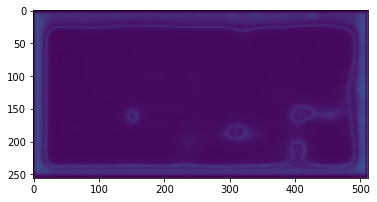

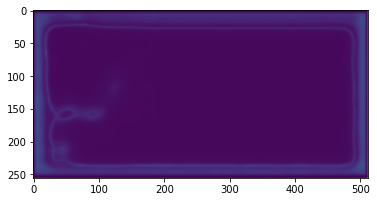

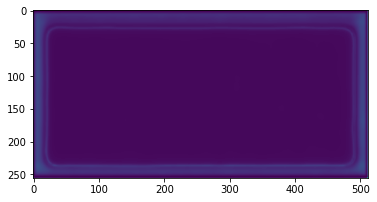

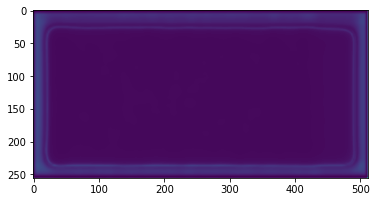

['130817 1 223489 1 316673 1 409345 1', '', '256 1 92928 1 130817 1 131072 1 186112 1 223489 1 223744 1 278784 1 316673 1 316928 1 409345 1 409600 1', '']


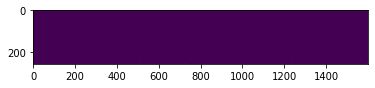

['4291 4 4537 16 4784 27 5030 39 5277 50 5524 60 5770 72 6020 80 6272 86 6525 91 6778 95 7030 101 7283 106 7536 111 7788 117 8041 121 8294 124 8546 128 8799 131 9052 134 9304 138 9557 142 9810 145 10062 149 10315 152 10568 155 10820 159 11073 162 11326 165 11579 168 11832 171 12085 175 12338 178 12591 181 12844 184 13097 187 13349 191 13602 194 13855 197 14108 200 14361 203 14614 207 14867 210 15120 213 15373 216 15627 218 15883 218 16138 219 16394 219 16650 219 16905 220 17161 220 17417 221 17672 222 17928 222 18184 222 18439 223 18695 223 18950 224 19206 224 19462 224 19717 225 19973 226 20229 226 20484 227 20740 227 20996 227 21251 228 21507 228 21763 228 22019 228 22275 228 22531 229 22787 229 23043 229 23299 229 23555 229 23811 229 24067 229 24323 229 24579 229 24835 229 25091 230 25347 230 25603 230 25859 230 26115 230 26371 230 26627 230 26883 230 27139 230 27396 229 27652 229 27908 229 28164 229 28420 229 28676 229 28932 229 29188 228 29444 228 29700 228 29956 228 30212 228 304

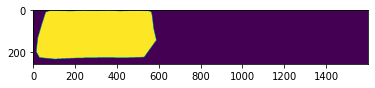

"\nfor i in range(0, test_imgs.shape[0], 500):\n    batch_idx = list( range(i, min(test_imgs.shape[0], i + 500)) )\n\n    for j, b in tqdm(enumerate(batch_idx)):\n        filename = test_imgs['ImageId'].iloc[b]\n        image_df = sub_df[sub_df['ImageId'] == filename].copy()\n        \n        pred_masks = batch_pred_masks[j, ].round().astype(int)\n        pred_rles = build_rles(pred_masks)\n        \n        image_df['EncodedPixels'] = pred_rles\n        test_df.append(image_df)\n\ntest_df = pd.concat(test_df)\ntest_df.drop(columns='ImageId', inplace=True)\ntest_df.to_csv('submission.csv', index=False)\n"

In [ ]:

#evaluation
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from segmentation_models import Unet
train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")

from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


no=[0,362,726,1088]
model = Unet('resnet34', input_shape=(256, 512, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
model.load_weights('/content/drive/My Drive/kaggle_data/weightlog/weight5model.h5')
#, custom_objects={'bce_dice_loss': bce_dice_loss,'dice_coef':dice_coef})
img = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train_images/"+train_df.iat[514,0])
img = [img[0:256,0:512] ,img[0:256,362:362+512],img[0:256,726:726+512],img[0:256,1088:1088+512]]

#img=img.reshape(256,512,3)
img = np.array(img)/255
#X.append(img)
X=np.array(img)
pred = model.predict(X, batch_size=1, verbose=0)
print(pred.shape)
C=pred[0]
C= C[:, :, 0] + C[:, :, 1] + C[:, :, 2]+ C[:, :, 3]
plt.imshow(C)
plt.show()
C=pred[1]
C= C[:, :, 0] + C[:, :, 1] + C[:, :, 2]+ C[:, :, 3]
plt.imshow(C)
plt.show()
C=pred[2]
C= C[:, :, 0] + C[:, :, 1] + C[:, :, 2]+ C[:, :, 3]
plt.imshow(C)
plt.show()
C=pred[3]
C= C[:, :, 0] + C[:, :, 1] + C[:, :, 2]+ C[:, :, 3]
plt.imshow(C)
plt.show()

def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles
B=np.zeros([256,1600])
B=np.array([B,B,B,B])
B=np.stack(B,2)
B[0:256,0:512]=B[0:256,0:512]+np.where(pred[0] > 0.02, 1, 0)
B[0:256,362:362+512]=B[0:256,362:362+512]+np.where(pred[1] > 0.02, 1, 0)
B[0:256,726:726+512]=B[0:256,726:726+512]+np.where(pred[2] > 0.02, 1, 0)
B[0:256,1088:1088+512]=B[0:256,1088:1088+512]+np.where(pred[3] > 0.02, 1, 0)
B=np.where(B >= 1, 1, 0)
print(build_rles(B))
B= B[:, :, 0] + B[:, :, 1] + B[:, :, 2]+ B[:, :, 3]
B=np.where(B >= 1, 1, 0)
plt.imshow(B)
plt.show()

def mask(gyo):
	train=train_df.iat[gyo,2].split(" ")
	train = [int(num) for num in train]
	mask = np.zeros(256*1600)
	mask=np.ravel(mask)

	for i in range(int(len(train)/2)):
		mask[train[2*i]:train[2*i]+train[2*i+1]-1]=[1]*(train[2*i+1]-1)
	mask=mask.reshape(1600,256)
	mask=mask.T
	mask.reshape(256,1600)
	mask=np.array(mask)
	return(train_df.iat[gyo,1],mask)
mas=mask(514)[1]
mas=mas.reshape(256,1600,1)
print(build_rles(mas))
mas=mas.reshape(256,1600)
plt.imshow(mas)
plt.show()

"""
for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list( range(i, min(test_imgs.shape[0], i + 500)) )

    for j, b in tqdm(enumerate(batch_idx)):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = sub_df[sub_df['ImageId'] == filename].copy()
        
        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks)
        
        image_df['EncodedPixels'] = pred_rles
        test_df.append(image_df)

test_df = pd.concat(test_df)
test_df.drop(columns='ImageId', inplace=True)
test_df.to_csv('submission.csv', index=False)
"""

In [ ]:
import os

# ファイル数を調べたいフォルダのパス
path = "/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/test_images/"

# フォルダ内の全ファイル名をリスト化
files = os.listdir(path)

# リストの長さ（ファイル数）を取得
count = len(files)

# ファイル数を確認
print(count)

760


In [ ]:

#evaluation
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")

from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

test_df=pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/sample_submission.csv")
imageid=[]
for i in range(len(test_df)):
  for j in range(4):
    imageid.append(test_df.iat[i,0]+"_"+str(j+1))
encode=['']*len(imageid)
df=pd.DataFrame({'ImageId_ClassId':imageid,'EncodedPixels':encode})


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

model = build_model((256, 1600, 1))


def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles
print(len(test_df))
model.load_weights('/content/drive/My Drive/kaggle_data/weight1/weights.3')
for i in range(len(test_df)):
  img = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/test_images/"+test_df.iat[i,0], cv2.IMREAD_GRAYSCALE)
  X=[]
  img=img.reshape(256,1600,1)
  img = np.array(img)/255
  X.append(img)
  X=np.array(X)
  pred = model.predict(X, batch_size=1, verbose=0)
  C=pred[0]
  C=np.where(C >0.6, 1, 0)
  C=build_rles(C)
  for j in range(4):
    df.iat[4*i+j,1]=C[j]
  if i%200==0:
    print(i)
  else:
    pass
df.head()
df.to_csv('/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/submission0.csv', index=False)

5506
0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400


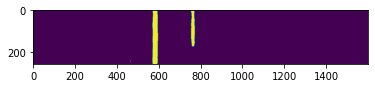

(256, 1600, 3)
(256, 1600, 3)


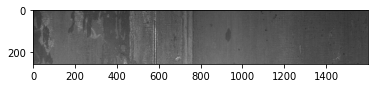

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


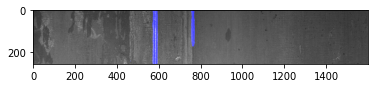

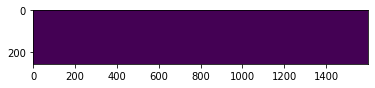

(256, 1600, 3)
(256, 1600, 3)


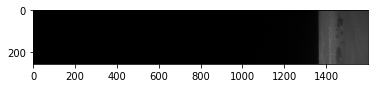

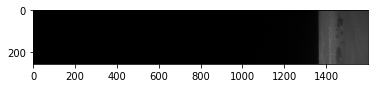

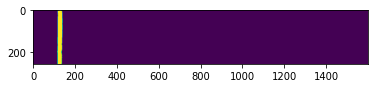

(256, 1600, 3)
(256, 1600, 3)


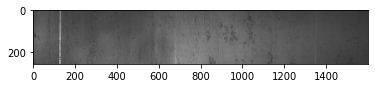

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


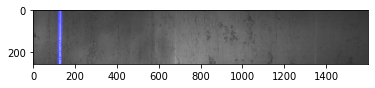

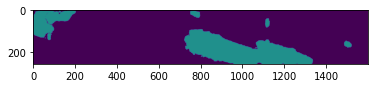

(256, 1600, 3)
(256, 1600, 3)


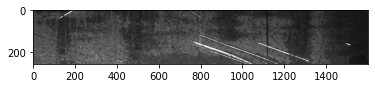

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


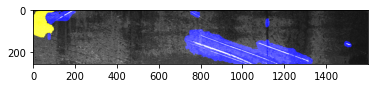

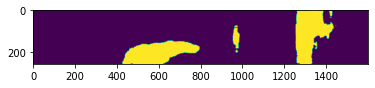

(256, 1600, 3)
(256, 1600, 3)


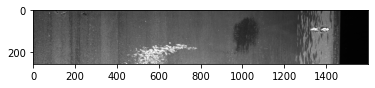

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


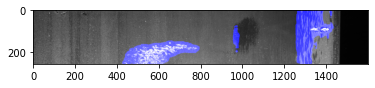

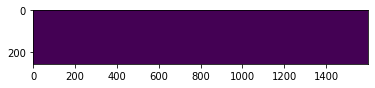

(256, 1600, 3)
(256, 1600, 3)


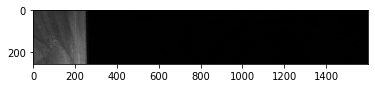

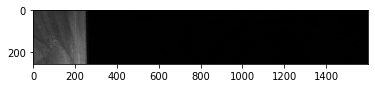

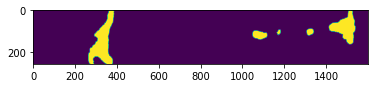

(256, 1600, 3)
(256, 1600, 3)


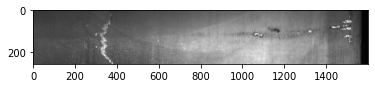

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


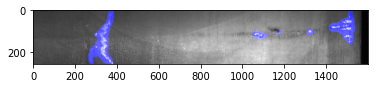

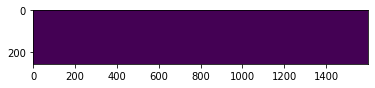

(256, 1600, 3)
(256, 1600, 3)


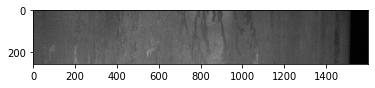

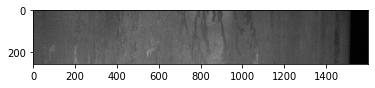

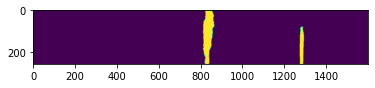

(256, 1600, 3)
(256, 1600, 3)


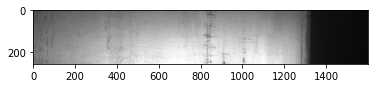

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


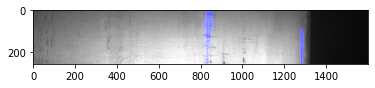

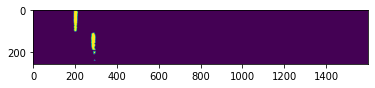

(256, 1600, 3)
(256, 1600, 3)


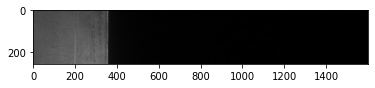

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


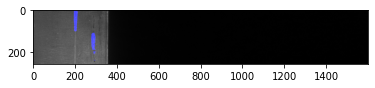

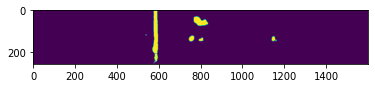

(256, 1600, 3)
(256, 1600, 3)


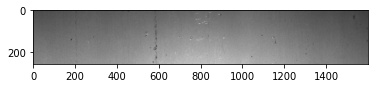

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


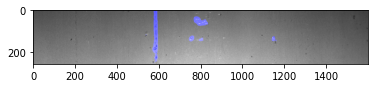

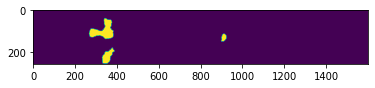

(256, 1600, 3)
(256, 1600, 3)


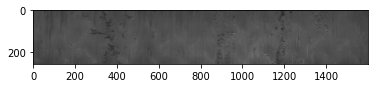

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


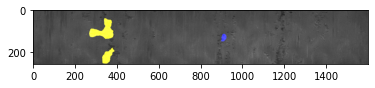

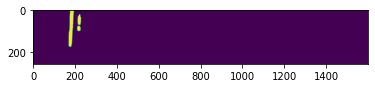

(256, 1600, 3)
(256, 1600, 3)


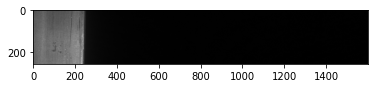

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


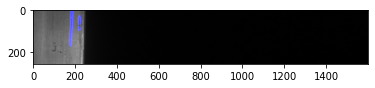

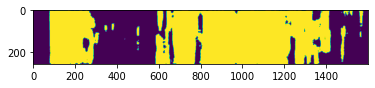

(256, 1600, 3)
(256, 1600, 3)


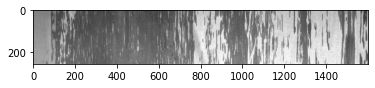

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


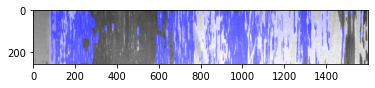

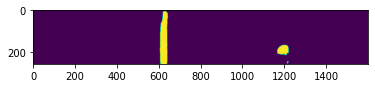

(256, 1600, 3)
(256, 1600, 3)


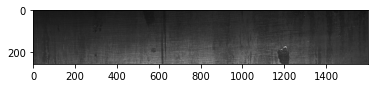

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


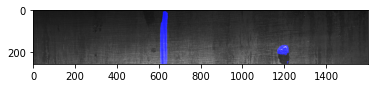

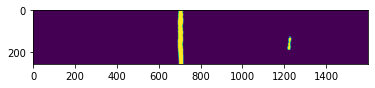

(256, 1600, 3)
(256, 1600, 3)


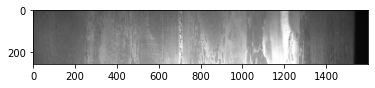

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


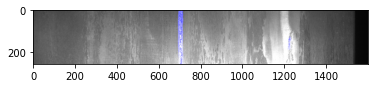

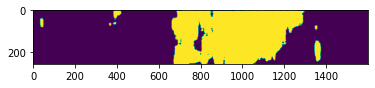

(256, 1600, 3)
(256, 1600, 3)


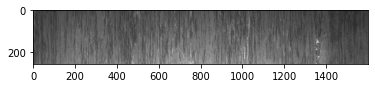

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


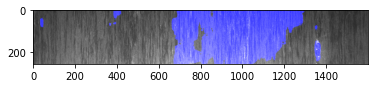

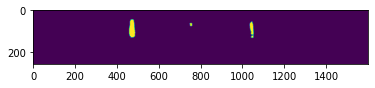

(256, 1600, 3)
(256, 1600, 3)


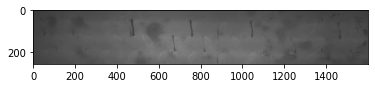

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


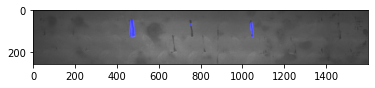

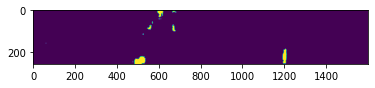

(256, 1600, 3)
(256, 1600, 3)


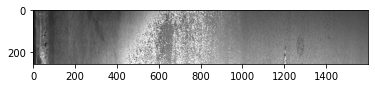

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


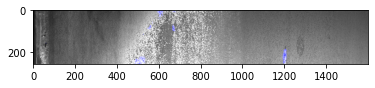

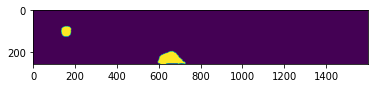

(256, 1600, 3)
(256, 1600, 3)


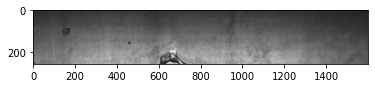

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


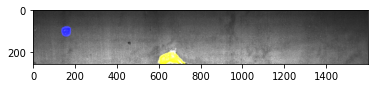

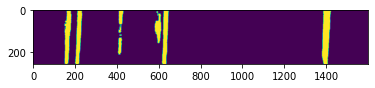

(256, 1600, 3)
(256, 1600, 3)


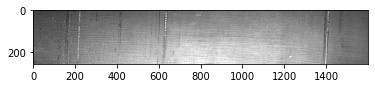

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


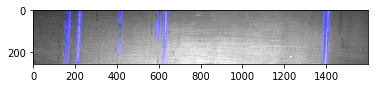

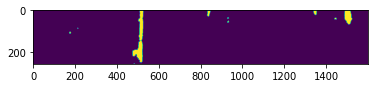

(256, 1600, 3)
(256, 1600, 3)


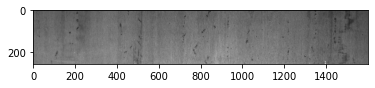

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


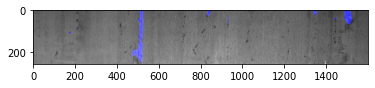

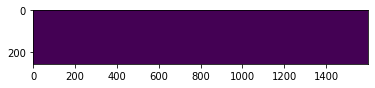

(256, 1600, 3)
(256, 1600, 3)


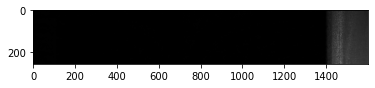

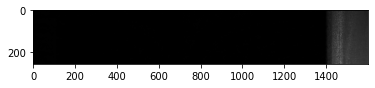

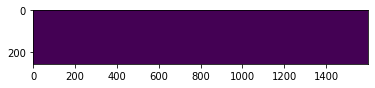

(256, 1600, 3)
(256, 1600, 3)


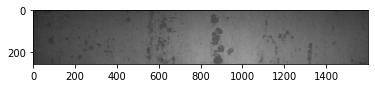

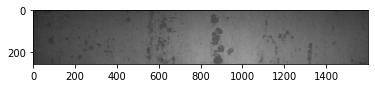

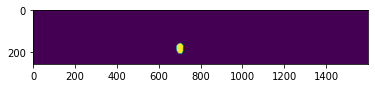

(256, 1600, 3)
(256, 1600, 3)


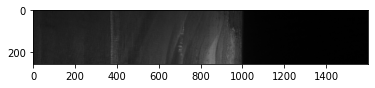

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


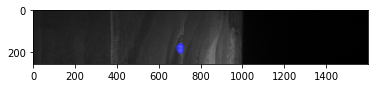

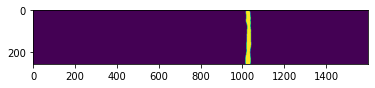

(256, 1600, 3)
(256, 1600, 3)


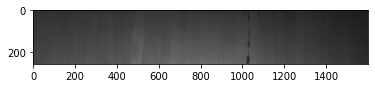

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


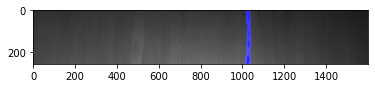

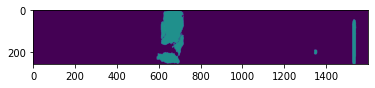

(256, 1600, 3)
(256, 1600, 3)


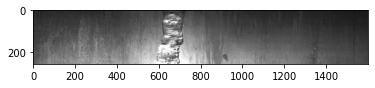

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


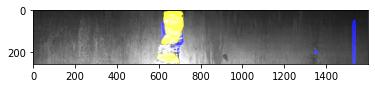

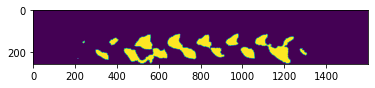

(256, 1600, 3)
(256, 1600, 3)


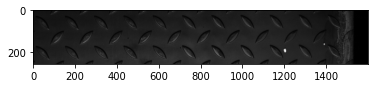

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


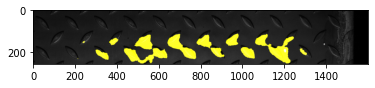

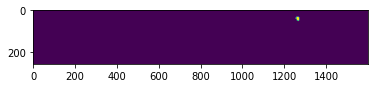

(256, 1600, 3)
(256, 1600, 3)


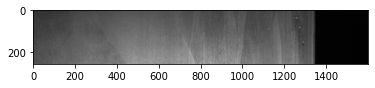

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


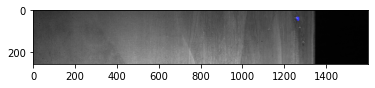

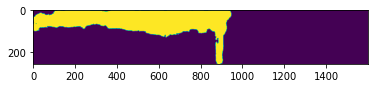

(256, 1600, 3)
(256, 1600, 3)


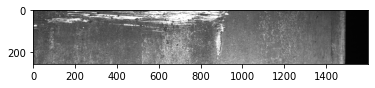

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


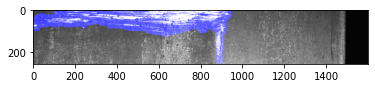

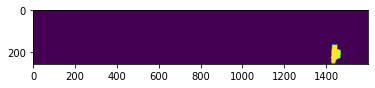

(256, 1600, 3)
(256, 1600, 3)


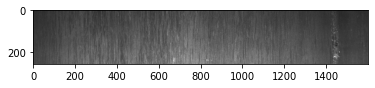

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


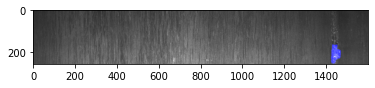

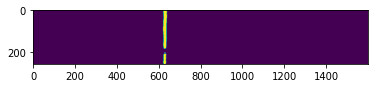

(256, 1600, 3)
(256, 1600, 3)


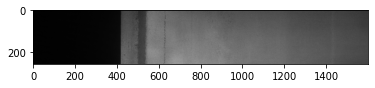

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


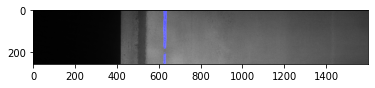

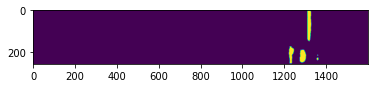

(256, 1600, 3)
(256, 1600, 3)


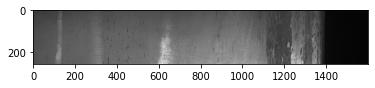

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


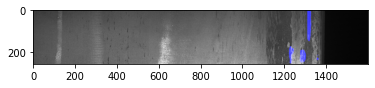

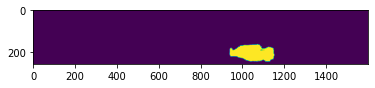

(256, 1600, 3)
(256, 1600, 3)


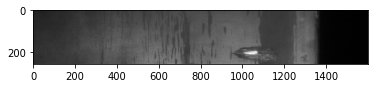

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


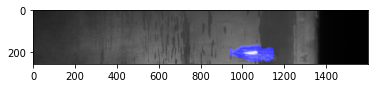

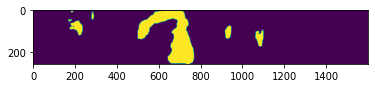

(256, 1600, 3)
(256, 1600, 3)


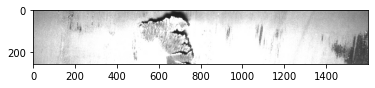

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


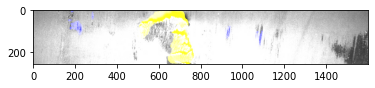

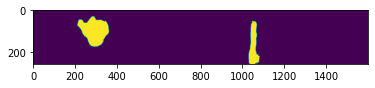

(256, 1600, 3)
(256, 1600, 3)


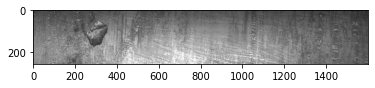

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


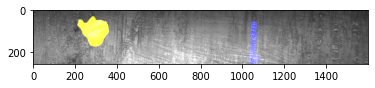

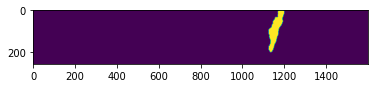

(256, 1600, 3)
(256, 1600, 3)


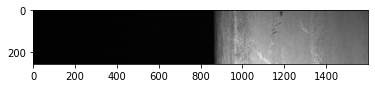

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


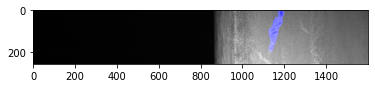

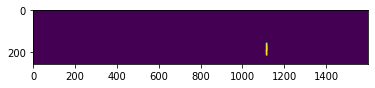

(256, 1600, 3)
(256, 1600, 3)


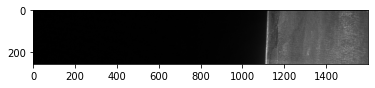

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


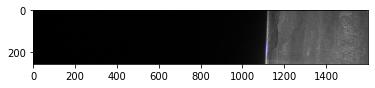

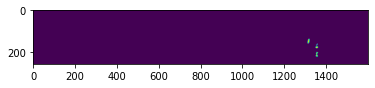

(256, 1600, 3)
(256, 1600, 3)


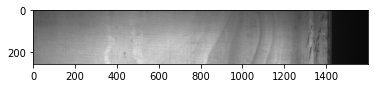

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


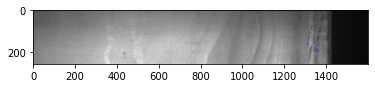

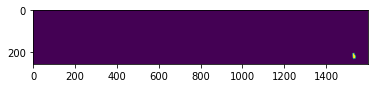

(256, 1600, 3)
(256, 1600, 3)


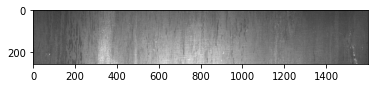

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


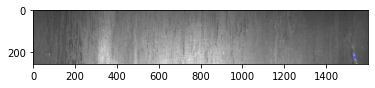

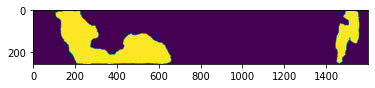

(256, 1600, 3)
(256, 1600, 3)


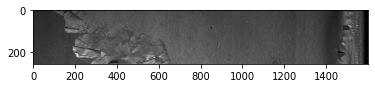

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


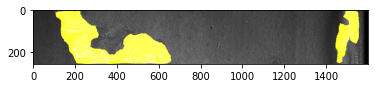

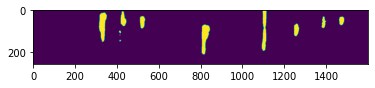

(256, 1600, 3)
(256, 1600, 3)


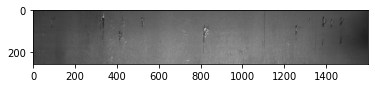

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


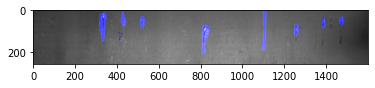

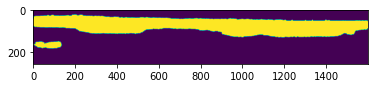

(256, 1600, 3)
(256, 1600, 3)


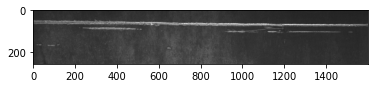

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


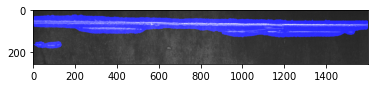

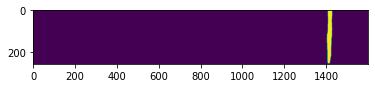

(256, 1600, 3)
(256, 1600, 3)


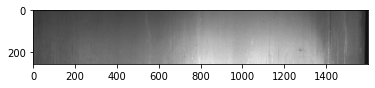

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


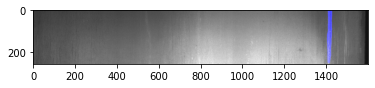

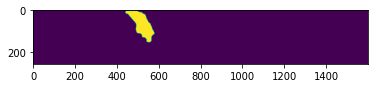

(256, 1600, 3)
(256, 1600, 3)


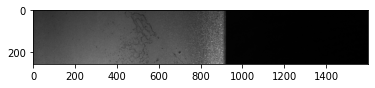

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


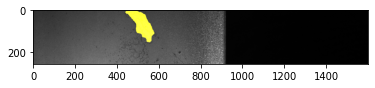

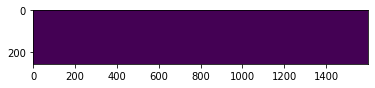

(256, 1600, 3)
(256, 1600, 3)


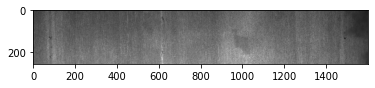

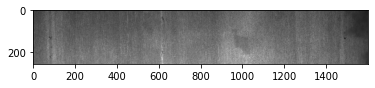

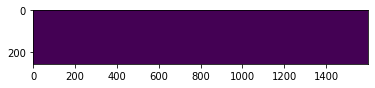

(256, 1600, 3)
(256, 1600, 3)


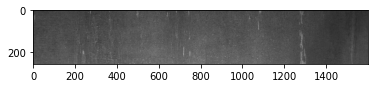

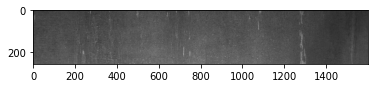

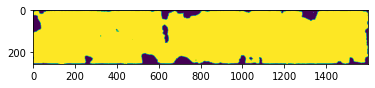

(256, 1600, 3)
(256, 1600, 3)


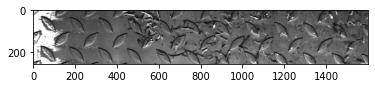

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


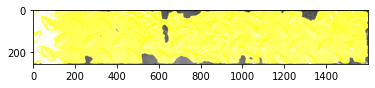

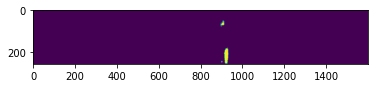

(256, 1600, 3)
(256, 1600, 3)


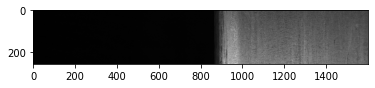

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


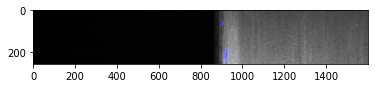

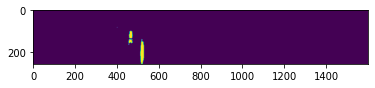

(256, 1600, 3)
(256, 1600, 3)


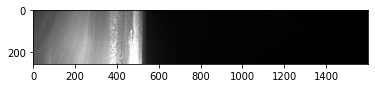

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


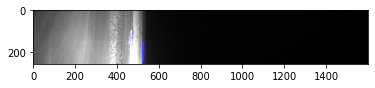

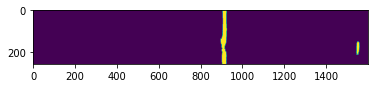

(256, 1600, 3)
(256, 1600, 3)


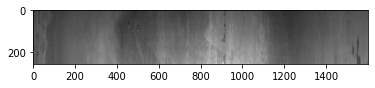

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


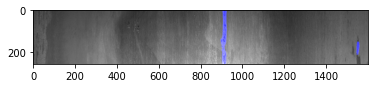

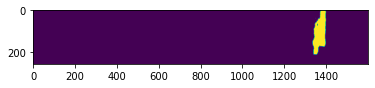

(256, 1600, 3)
(256, 1600, 3)


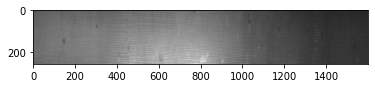

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


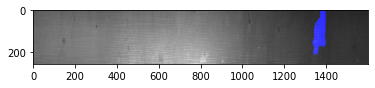

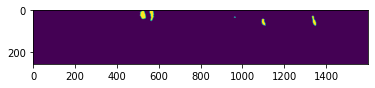

(256, 1600, 3)
(256, 1600, 3)


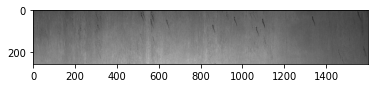

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


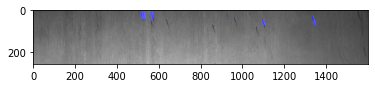

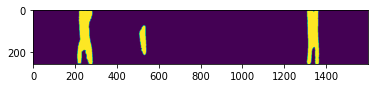

(256, 1600, 3)
(256, 1600, 3)


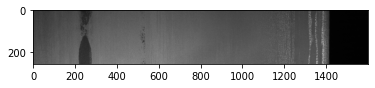

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


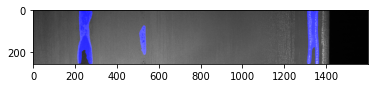

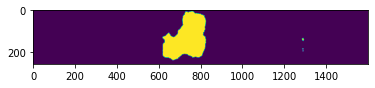

(256, 1600, 3)
(256, 1600, 3)


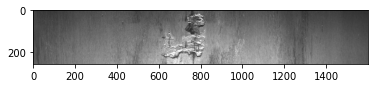

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


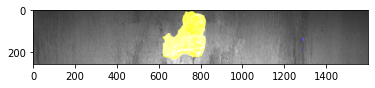

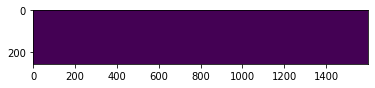

(256, 1600, 3)
(256, 1600, 3)


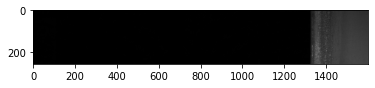

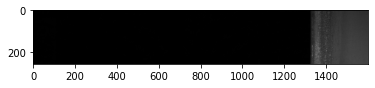

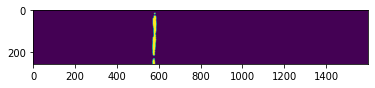

(256, 1600, 3)
(256, 1600, 3)


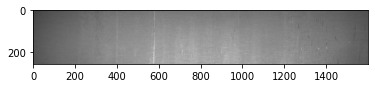

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


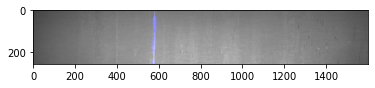

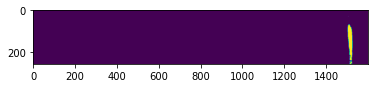

(256, 1600, 3)
(256, 1600, 3)


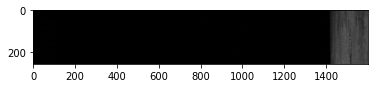

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


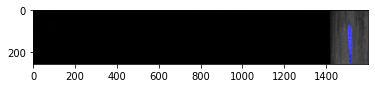

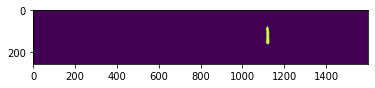

(256, 1600, 3)
(256, 1600, 3)


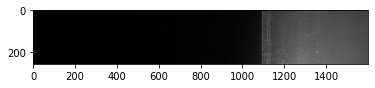

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


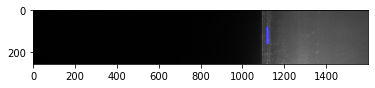

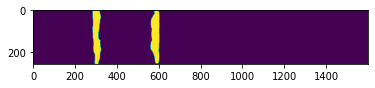

(256, 1600, 3)
(256, 1600, 3)


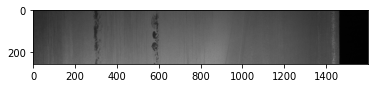

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


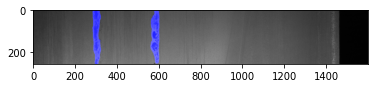

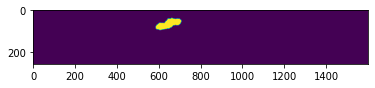

(256, 1600, 3)
(256, 1600, 3)


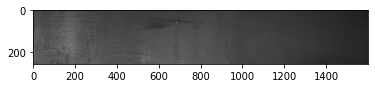

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


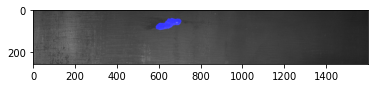

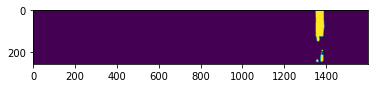

(256, 1600, 3)
(256, 1600, 3)


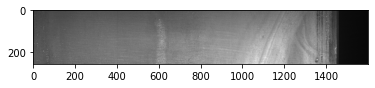

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


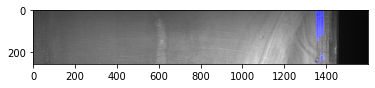

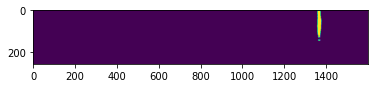

(256, 1600, 3)
(256, 1600, 3)


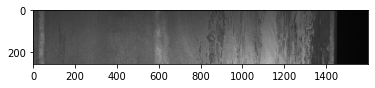

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


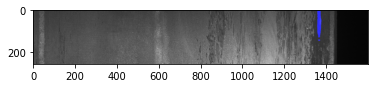

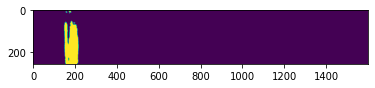

(256, 1600, 3)
(256, 1600, 3)


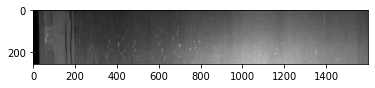

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


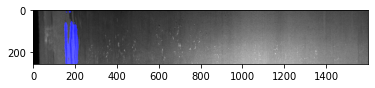

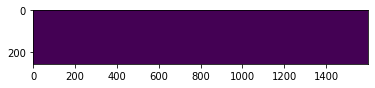

(256, 1600, 3)
(256, 1600, 3)


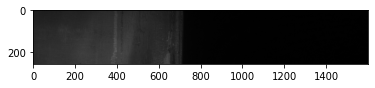

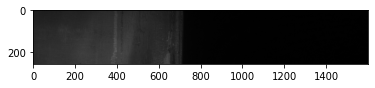

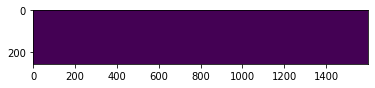

(256, 1600, 3)
(256, 1600, 3)


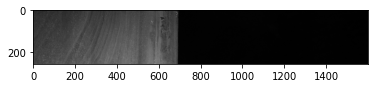

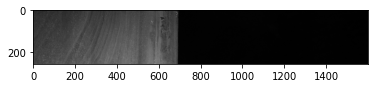

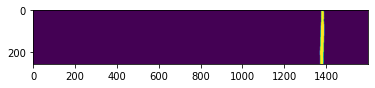

(256, 1600, 3)
(256, 1600, 3)


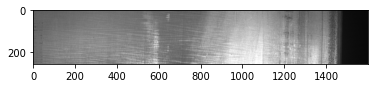

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


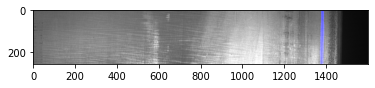

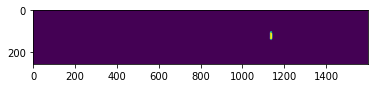

(256, 1600, 3)
(256, 1600, 3)


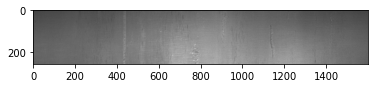

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


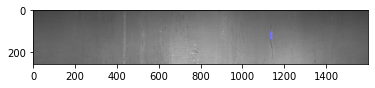

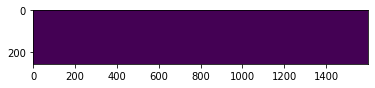

(256, 1600, 3)
(256, 1600, 3)


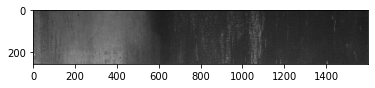

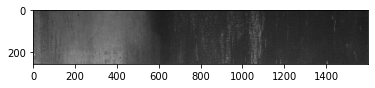

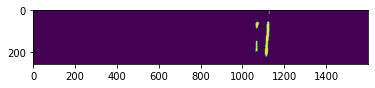

(256, 1600, 3)
(256, 1600, 3)


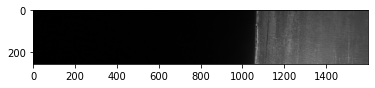

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


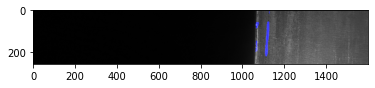

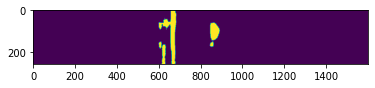

(256, 1600, 3)
(256, 1600, 3)


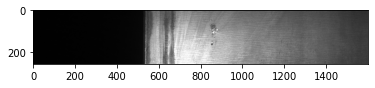

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


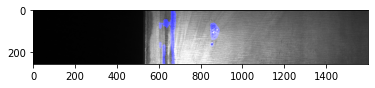

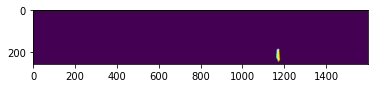

(256, 1600, 3)
(256, 1600, 3)


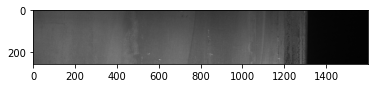

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


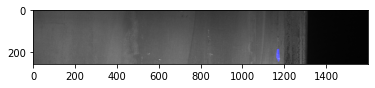

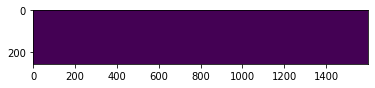

(256, 1600, 3)
(256, 1600, 3)


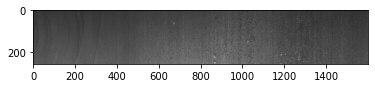

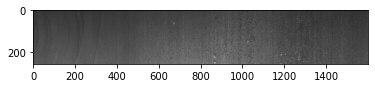

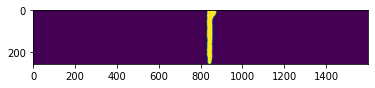

(256, 1600, 3)
(256, 1600, 3)


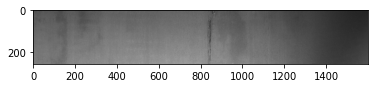

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


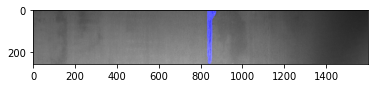

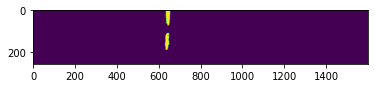

(256, 1600, 3)
(256, 1600, 3)


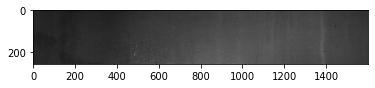

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


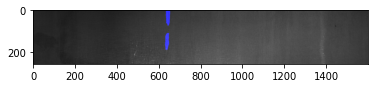

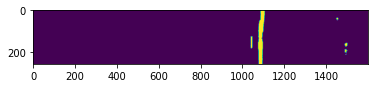

(256, 1600, 3)
(256, 1600, 3)


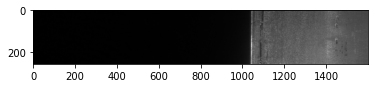

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


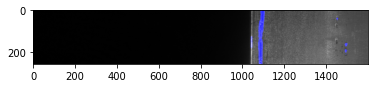

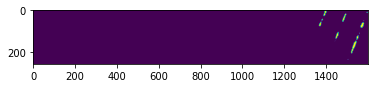

(256, 1600, 3)
(256, 1600, 3)


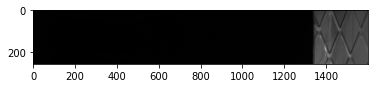

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


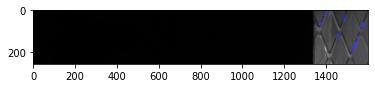

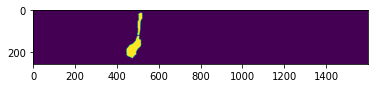

(256, 1600, 3)
(256, 1600, 3)


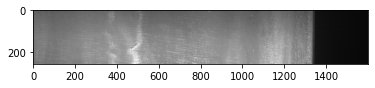

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


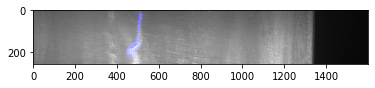

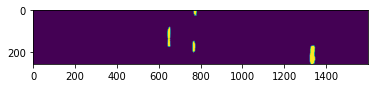

(256, 1600, 3)
(256, 1600, 3)


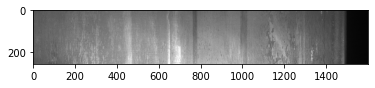

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


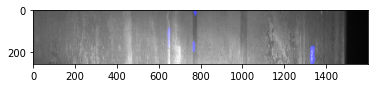

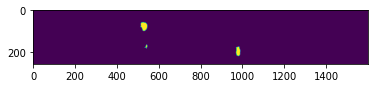

(256, 1600, 3)
(256, 1600, 3)


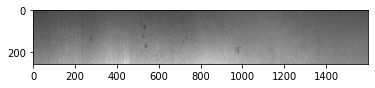

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


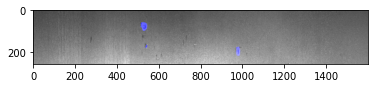

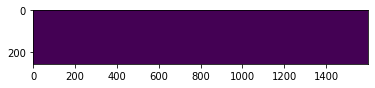

(256, 1600, 3)
(256, 1600, 3)


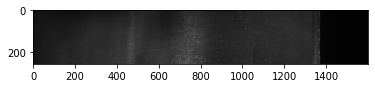

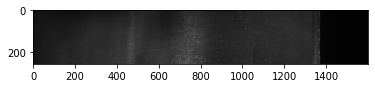

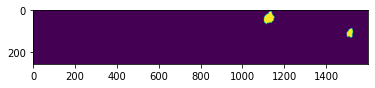

(256, 1600, 3)
(256, 1600, 3)


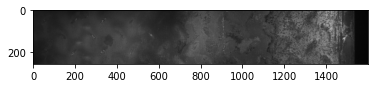

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


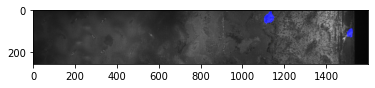

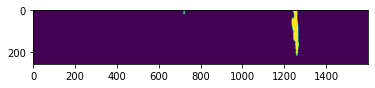

(256, 1600, 3)
(256, 1600, 3)


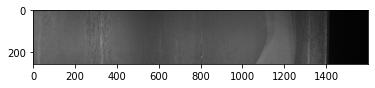

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


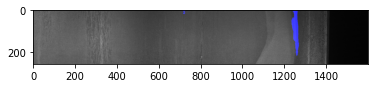

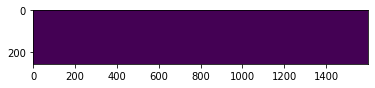

(256, 1600, 3)
(256, 1600, 3)


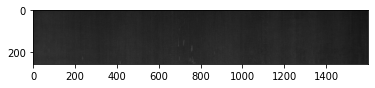

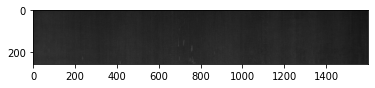

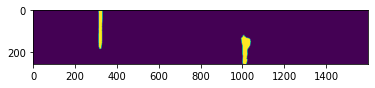

(256, 1600, 3)
(256, 1600, 3)


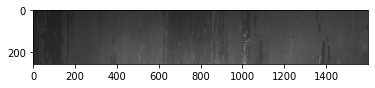

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


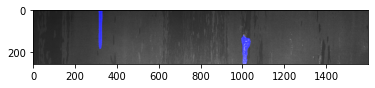

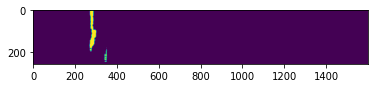

(256, 1600, 3)
(256, 1600, 3)


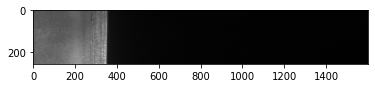

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


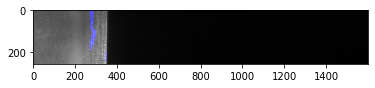

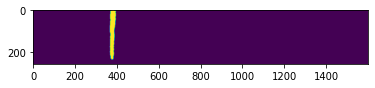

(256, 1600, 3)
(256, 1600, 3)


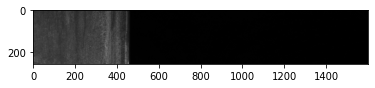

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


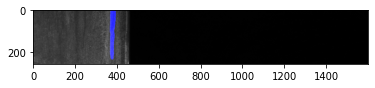

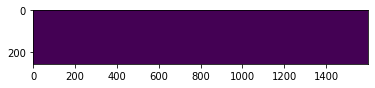

(256, 1600, 3)
(256, 1600, 3)


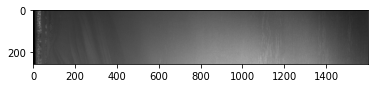

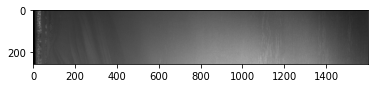

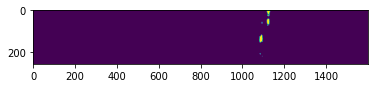

(256, 1600, 3)
(256, 1600, 3)


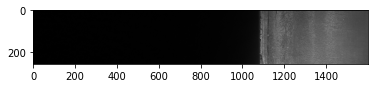

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


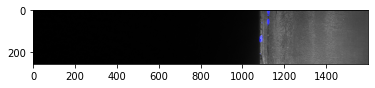

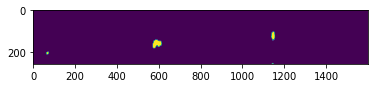

(256, 1600, 3)
(256, 1600, 3)


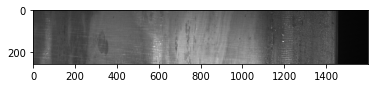

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


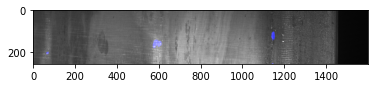

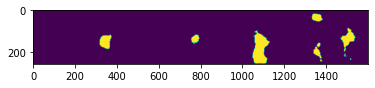

(256, 1600, 3)
(256, 1600, 3)


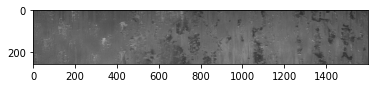

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


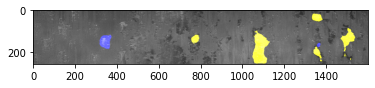

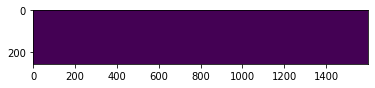

(256, 1600, 3)
(256, 1600, 3)


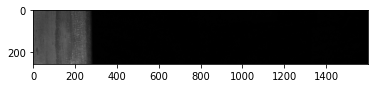

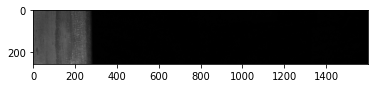

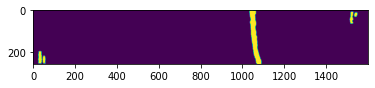

(256, 1600, 3)
(256, 1600, 3)


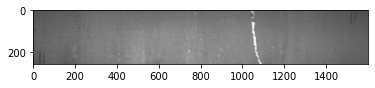

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


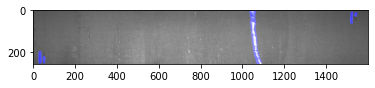

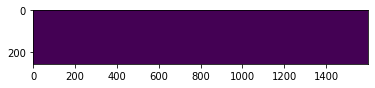

(256, 1600, 3)
(256, 1600, 3)


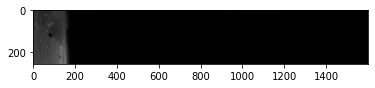

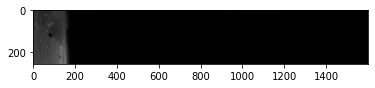

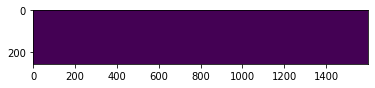

(256, 1600, 3)
(256, 1600, 3)


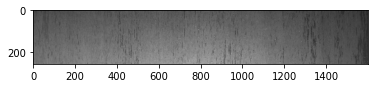

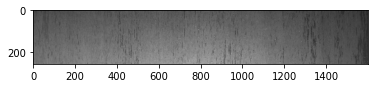

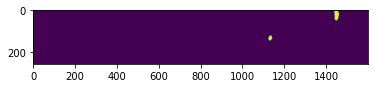

(256, 1600, 3)
(256, 1600, 3)


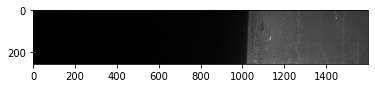

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


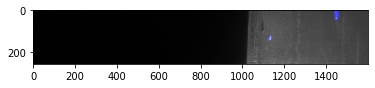

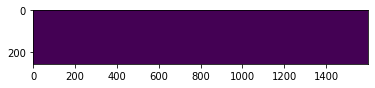

(256, 1600, 3)
(256, 1600, 3)


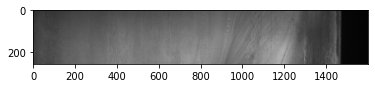

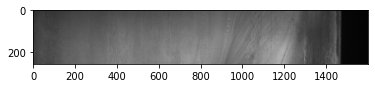

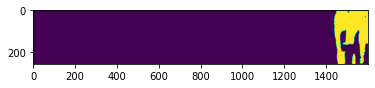

(256, 1600, 3)
(256, 1600, 3)


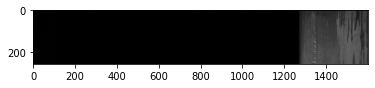

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


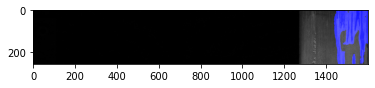

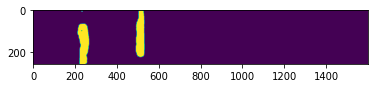

(256, 1600, 3)
(256, 1600, 3)


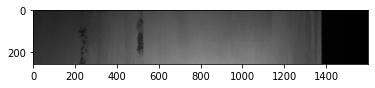

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


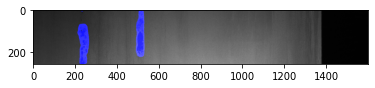

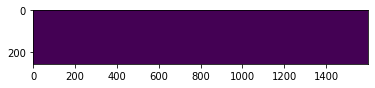

(256, 1600, 3)
(256, 1600, 3)


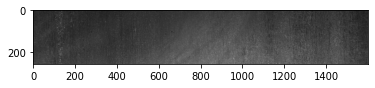

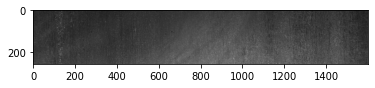

In [31]:
#test data&mask
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")

from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

test_df=pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/sample_submission.csv")
imageid=[]
for i in range(len(test_df)):
  for j in range(4):
    imageid.append(test_df.iat[i,0]+"_"+str(j+1))
encode=['']*len(imageid)
df=pd.DataFrame({'ImageId_ClassId':imageid,'EncodedPixels':encode})


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def build_model(input_shape):
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
    
    return model

model = build_model((256, 1600, 1))


def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks):
    width, height, depth = masks.shape
    
    rles = [mask2rle(masks[:, :, i])
            for i in range(depth)]
    
    return rles
model.load_weights('/content/drive/My Drive/kaggle_data/weight1/weights.3')
#for i in range(len(test_df)):
for k in range(100):
  img = cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/test_images/"+test_df.iat[k,0], cv2.IMREAD_GRAYSCALE)
  X=[]
  img=img.reshape(256,1600,1)
  img = np.array(img)/255
  X.append(img)
  X=np.array(X)
  pred = model.predict(X, batch_size=1, verbose=0)
  C=pred[0]
  C=np.where(C >0.6, 1, 0)
  B= C[:, :, 0] + C[:, :, 1] + C[:, :, 2]+ C[:, :, 3]
  plt.imshow(B)
  plt.show()
  img=cv2.imread("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/test_images/"+test_df.iat[k,0])
  img=img/255
  mask=np.zeros((256,1600,3))
  c1=C[:,:,0]
  for i in range(256):
    for j in range(1600):
      if c1[i,j]==1:
        mask[i,j,0]=255
      else:
        pass

  c2=C[:,:,1]
  for i in range(256):
    for j in range(1600):
      if c2[i,j]==1:
        mask[i,j,1]=255
      else:
        pass

  c3=C[:,:,2]
  for i in range(256):
    for j in range(1600):
      if c3[i,j]==1:
        mask[i,j,2]=255
      else:
        pass

  c4=C[:,:,3]
  for i in range(256):
    for j in range(1600):
      if c4[i,j]==1:
        mask[i,j,0]=255
        mask[i,j,1]=102
      else:
        pass

  print(mask.shape)
  print(img.shape)
  maskimg = img+0.01*mask
  plt.imshow(img,vmin = 0, vmax = 255)
  plt.show()
  plt.imshow(maskimg, vmin = 0, vmax = 255)
  plt.show()

In [ ]:
#evaluation
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/submission0.csv")
df.tail()

ImageId_ClassId                                      EncodedPixels
22019  fff4fd9bb.jpg_4  232247 2 232502 6 232758 7 233013 10 233268 12...
22020  fff598023.jpg_1                                                NaN
22021  fff598023.jpg_2                                                NaN
22022  fff598023.jpg_3  279813 4 280067 15 280323 28 280352 1 280571 3...
22023  fff598023.jpg_4                                                NaN

In [ ]:
#evaluation
import os
import json
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
train_df = pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/train.csv")

from keras.models import load_model
import numpy as np
from keras.preprocessing.image import img_to_array, load_img

%matplotlib inline


test_df=pd.read_csv("/content/drive/My Drive/kaggle_data/severstal-steel-defect-detection/sample_submission.csv")
imageid=[]
for i in range(len(test_df)):
  for j in range(4):
    imageid.append(test_df.iat[i,0]+"_"+str(j+1))
encode=[np.nan]*len(imageid)
df=pd.DataFrame({'ImageId_ClassId':imageid,'EncodedPixels':encode})

df.head()

ImageId_ClassId  EncodedPixels
0  0000f269f.jpg_1            NaN
1  0000f269f.jpg_2            NaN
2  0000f269f.jpg_3            NaN
3  0000f269f.jpg_4            NaN
4  000ccc2ac.jpg_1            NaN

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

In [ ]:
!git clone https://github.com/NVIDIA/cuda-samples/
!cp cuda-samples/Common/* /usr/local/include

In [ ]:
!/usr/local/cuda/bin/nvcc --version